In [2]:
import keras
import pandas as pd
from glob import glob
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

Using TensorFlow backend.


## Load Model

In [72]:
vgglike_model=keras.models.load_model('base_2017-11-05-09-51-09_final_model.hdf5')
cnn_model=keras.models.load_model('base_2017-11-05-09-51-09_final_model.hdf5')

vgglike_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 510, 510, 32)      896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 508, 508, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 252, 252, 64)      18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 250, 250, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 123, 123, 96)      55392     
__________

## Parameter

In [23]:
width  =512
height =512
num_classes = 5

## Function

In [82]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    #img_path = path
    #img = image.load_img(path, target_size=(width, height))
    #x = image.img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    img = cv2.imread(path)
    img = cv2.resize(img,(width,height))
    x = np.array([img])
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='con'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model



def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = num_classes
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers[0].layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (width, height))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    #image -= np.min(image)
    #image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    #cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_HOT)
    
    cam = 0.4*np.float32(cam) + 0.6*np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap


## Crop Original Image

In [ ]:
img_file = train_files[4]
print(img_file)
img = cv2.imread(img_file)
print(img.shape)
plt.imshow(img)

def estimate_radius(img):
    mx = img[img.shape[0] // 2,:,:].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2
    
    my = img[:,img.shape[1] // 2,:].sum(1)
    ry = (my > my.mean() / 10).sum() / 2

    return (ry, rx)

ry, rx = estimate_radius(img)

resize_scale = scale / max(rx, ry)
w = min(int(rx * resize_scale * 2), scale * 2)
h = min(int(ry * resize_scale * 2), scale * 2)
img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)
print(img_resize.shape)
plt.imshow(img_resize)

def crop_img(img, h, w):
    h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
    w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

    crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]

    return crop_img

print(h, w)
img_crop = crop_img(img_resize.copy(), h, w)
print(img_crop.shape)
plt.imshow(img_crop)

## Gradient CAM

In [89]:
def CAM(PATH,layername):
    preprocessed_input = load_image(PATH)
    predictions = cnn_model.predict(preprocessed_input)
    #print(predictions[0][2])
    predicted_class = np.argmax(predictions)
    cam, heatmap = grad_cam(cnn_model, preprocessed_input, predicted_class,layername)
    return cv2.imread(PATH),cam,heatmap

def show_cam_images(PATH,layername):
    origin,cam,heatmap=CAM(PATH,layername)
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cam)
    plt.subplot(1, 3, 2)
    plt.imshow(origin)
    plt.subplot(1, 3, 3)
    plt.imshow(heatmap)
    plt.show()

## Find Img in different Levels

In [86]:
def get_Img(level):
    
    cnt =0
    abnormal=[]
    for path in os.listdir('../input/512/train/'):
        img = cv2.imread(os.path.join('../input/512/train/',path))
        img = cv2.resize(img,(width,height))
        x = np.array([img])
        y = cnn_model.predict(x)
        if(y[0][level]> 0.7):
            print(y[0][level])
            cnt+=1
            abnormal.append(path)
        if cnt ==5 :
            break
    return abnormal

## Level 2

0.917954
0.764119
0.887648
0.856364
0.878336


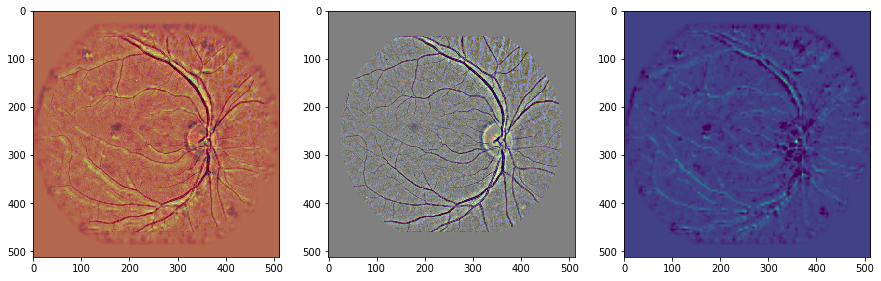

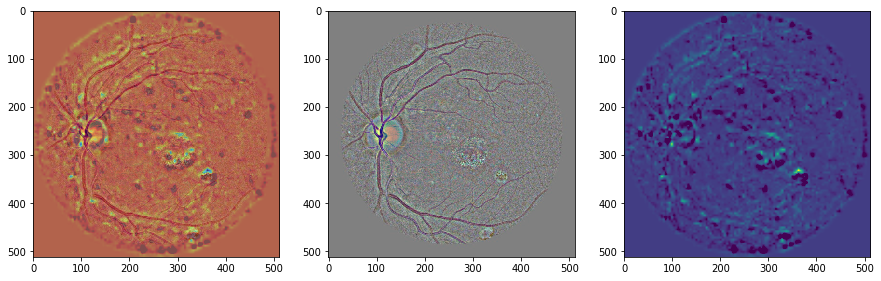

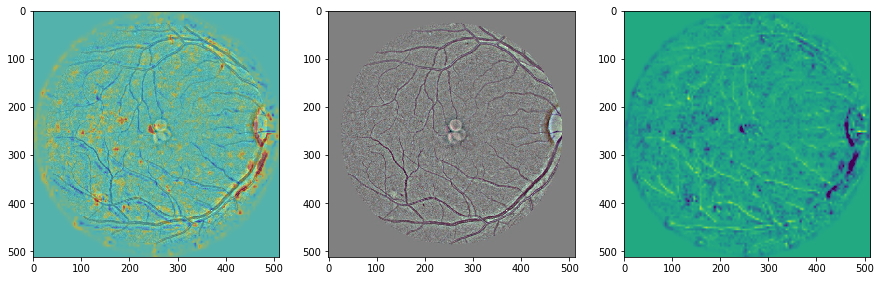

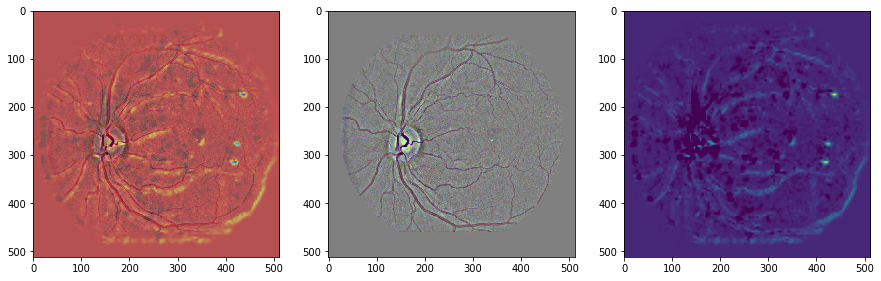

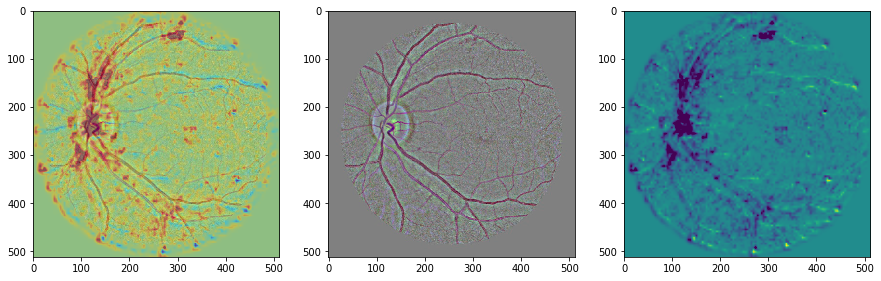

In [93]:
abnormal2 = get_Img(2)
for name in abnormal2:
    show_cam_images(os.path.join('../input/512/train/',name),'conv2d_19')

## Different layer OutPut

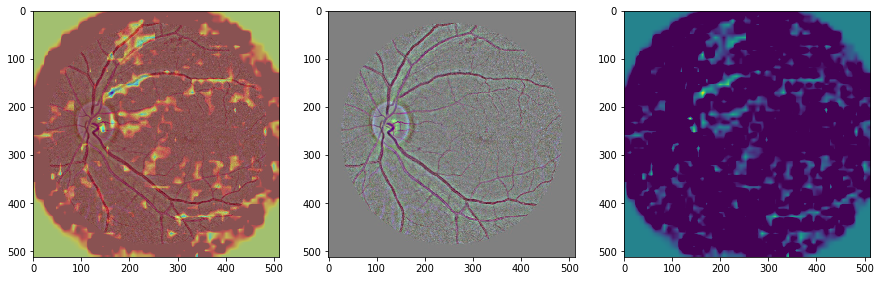

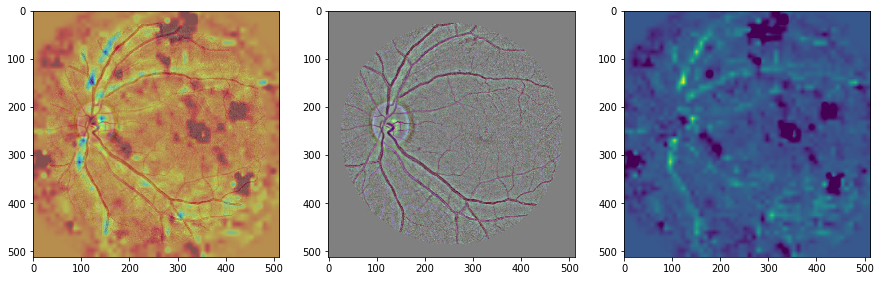

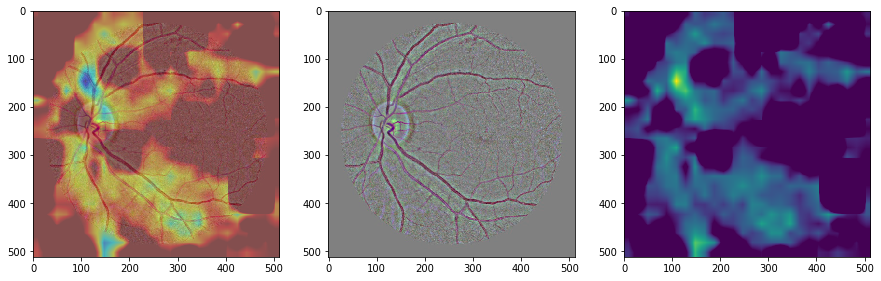

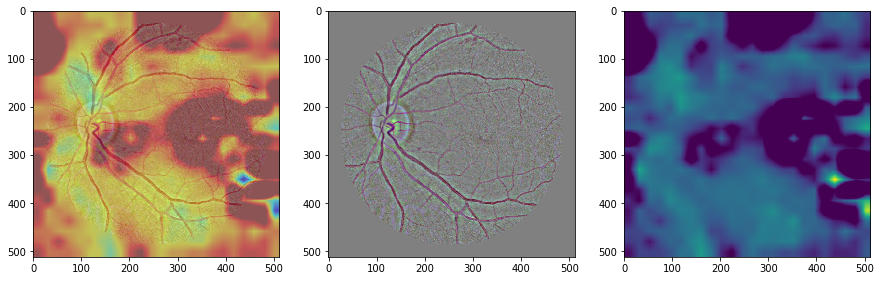

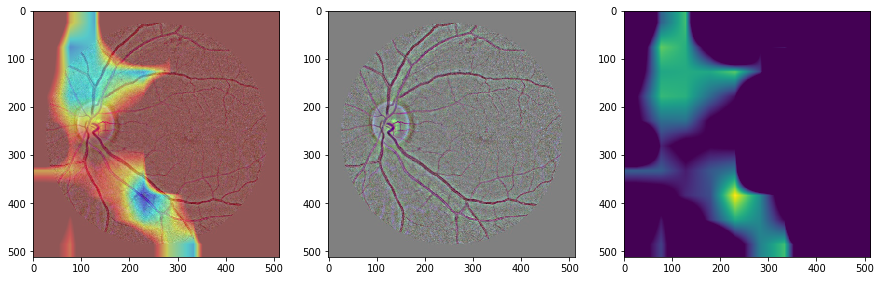

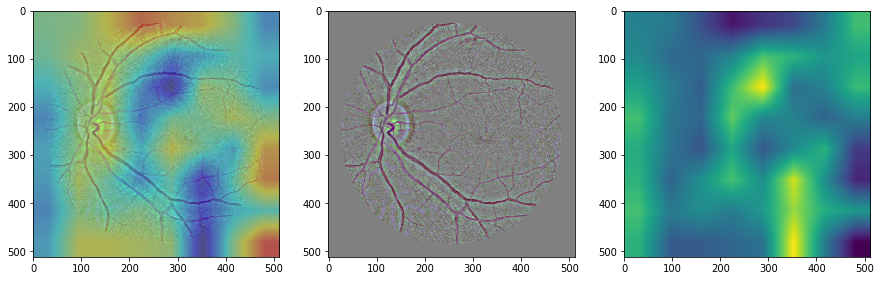

In [97]:
for i in range(20,26):
    show_cam_images(os.path.join('../input/512/train/',name),'conv2d_'+str(i))